In [10]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from simdata import HT_sim, scaler,fdd, pdeinp,icinp,bcinp


In [11]:
L = 15e-3

time_end = 40.0
numpoints = 50
t_surr = 500.0
temp_init = 919.0



In [12]:
heat_data = HT_sim(L, time_end, numpoints,  t_surr,temp_init)
alpha = heat_data.alpha_l
print(alpha)
tempfield = heat_data.datagen()

# heat_data.plot_temp(25)
x_c = 1/L
t_c = (alpha/(L**2))
temp_c = 919.0

# Temperature dataset
temp_data = tempfield.flatten()

temp_data = temp_data*(1.0/t_c)

# temp_data = scaler(temp_data,400.0,919.0)


# input dataset- fdd
num_steps = tempfield.shape[0]
numpoints = tempfield.shape[1] 
print(numpoints, num_steps)
print(numpoints*num_steps) 
inp_data = fdd(15e-3, 40, numpoints, num_steps,scl="false")



3.394878564540885e-05
50 31470
1573500


In [13]:
def pde(x, y):
    # pde for heat equation
    dy_t = dde.grad.jacobian(y, x, j=0)
    dy_xx = dde.grad.hessian(y, x, j=1)
    return dy_t - dy_xx

def scale2(x,x_c,t_c):
    x[:,0] = x[:,0] * x_c
    x[:,1] = x[:,1] * t_c
    return x

In [14]:
geom = dde.geometry.Interval(0, (L*x_c))
timedomain = dde.geometry.TimeDomain(0, (time_end*t_c))
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.DirichletBC(geomtime, lambda x: (500.0/t_c), lambda _, on_boundary: on_boundary)

ic = dde.IC(geomtime, lambda x: (919.0/t_c), lambda _, on_initial: on_initial)

In [15]:
data = dde.data.TimePDE(geomtime, \
                        pde,\
                        [bc, ic], \
                      num_domain=10000, \
                     num_boundary=10000, \
                        num_initial=10000, num_test=10000)

In [16]:
net = dde.maps.FNN([2] + [5] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)



In [17]:
model.compile("adam", lr=0.001)
model.train(iterations=10000)
model.compile("L-BFGS-B")

losshistory, train_state = model.train()

Compiling model...
'compile' took 0.000297 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [6.14e-03, 1.10e+07, 3.71e+07]    [6.59e-03, 1.10e+07, 3.71e+07]    []  
1000      [2.79e-03, 1.09e+07, 3.70e+07]    [4.89e-04, 1.09e+07, 3.70e+07]    []  
2000      [1.72e-04, 1.09e+07, 3.69e+07]    [2.77e-05, 1.09e+07, 3.69e+07]    []  
3000      [2.62e-05, 1.08e+07, 3.68e+07]    [4.08e-06, 1.08e+07, 3.68e+07]    []  
4000      [5.63e-06, 1.08e+07, 3.68e+07]    [8.53e-07, 1.08e+07, 3.68e+07]    []  
5000      [1.43e-06, 1.08e+07, 3.67e+07]    [2.12e-07, 1.08e+07, 3.67e+07]    []  
6000      [3.99e-07, 1.07e+07, 3.66e+07]    [5.78e-08, 1.07e+07, 3.66e+07]    []  
7000      [1.18e-07, 1.07e+07, 3.65e+07]    [1.67e-08, 1.07e+07, 3.65e+07]    []  
8000      [3.65e-08, 1.06e+07, 3.65e+07]    [5.05e-09, 1.06e+07, 3.65e+07]    []  
9000      [1.16e-08, 1.06e+07, 3.64e+07]    [1.56e-09, 1.06e+07, 3.64e+07]    []  
10000     [3.76

(1573500, 1)
(31470, 50)


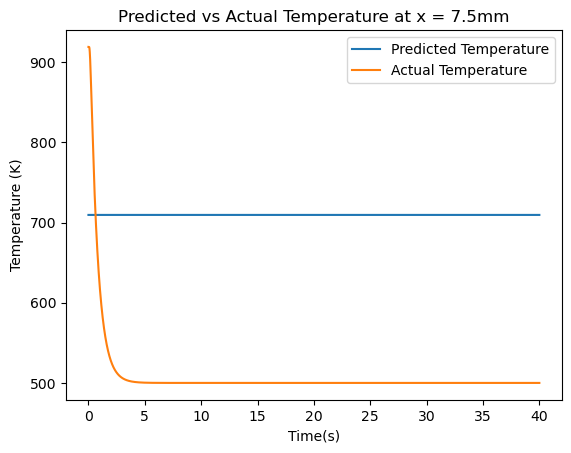

In [19]:
y_pred = model.predict(inp_data)
y_pred = y_pred * t_c
print(y_pred.shape)
temp_nn = y_pred.reshape(num_steps, numpoints)
print(temp_nn.shape)
time_ss= np.linspace(0, 40.0, num_steps )

plt.figure
plt.plot(time_ss, temp_nn[:,25 ], label='Predicted Temperature')
plt.plot(time_ss, tempfield[:,25], label='Actual Temperature')
plt.xlabel('Time(s)')
plt.ylabel('Temperature (K)')
plt.yscale('linear')
plt.title('Predicted vs Actual Temperature at x = 7.5mm')
plt.legend()
plt.show()

